# Comparing the EDM score with the Score of GMM and delta.

### Import utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import join
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image

In [6]:
# set pandas display
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/DiffusionMemorization")
from train_edm import edm_sampler, EDM, create_model
from core.edm_utils import get_default_config, create_edm

### Load Dataset

In [4]:
# load CIFAR10 data

train_dataset = datasets.CIFAR10(root='~/Datasets', download=True, transform=\
    transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

Files already downloaded and verified


In [5]:
Xtsr = torch.stack([x for x, y in train_dataset])
ytsr = torch.tensor(train_dataset.targets)
Xtsr = Xtsr.float()
Xmat = Xtsr.view(Xtsr.shape[0], -1)
imgshape = tuple(Xtsr.shape[1:])
print(imgshape)
Xmean = Xmat.mean(dim=0)
Xcov = torch.cov(Xmat.T, )
eigvals, eigvecs = torch.linalg.eigh(Xcov.cuda(), )
torch.sum(eigvals).sqrt()

(3, 32, 32)


tensor(27.5973, device='cuda:0')

### Testing gen samples

In [38]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_cifar10_20240130-2317/checkpoints"
config = get_default_config("cifar10")
epoch = 2000
edm, _ = create_edm(join(ckptdir, f"ema_{epoch}.pth"), config,)

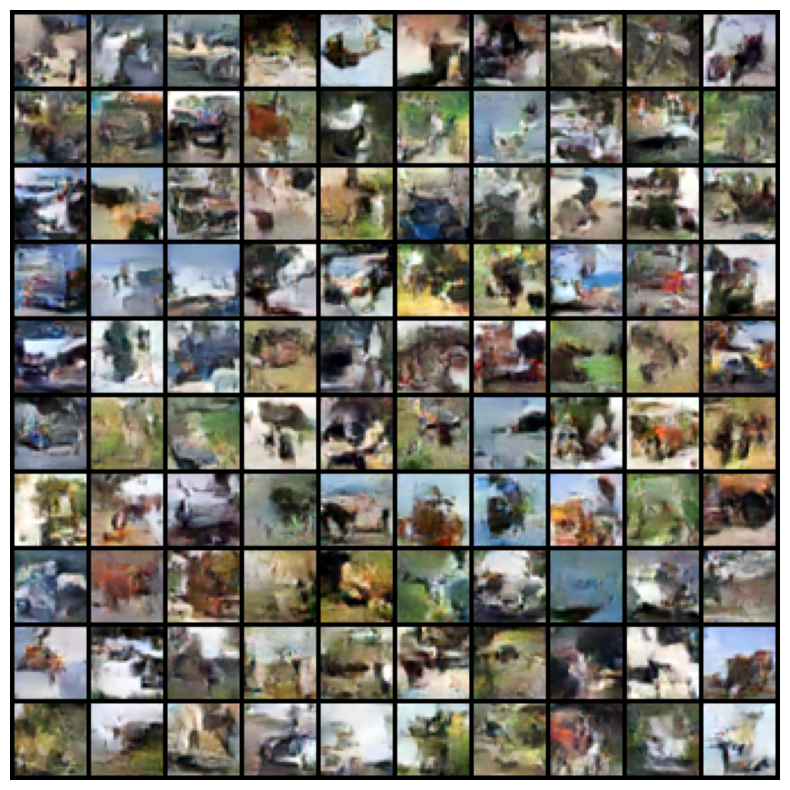

In [41]:
batch_size = 100
seed = 42
total_steps = 35
with torch.no_grad():
    noise = torch.randn([batch_size, config.channels, config.img_size, config.img_size],
                        generator=torch.cuda.manual_seed(seed), device=config.device)
    samples = edm_sampler(edm, noise, num_steps=total_steps, use_ema=True).detach().cpu()
    samples.mul_(0.5).add_(0.5)
samples = torch.clamp(samples, 0., 1.).cpu()

plt.figure(figsize=(10, 10))
plt.imshow((make_grid(samples*255.0, nrow=10).permute(1, 2, 0)).numpy().astype(np.uint8))
plt.axis('off')
plt.show()

### Test score approximators as a function of training 

In [7]:
from core.analytical_score_lib import mean_isotropic_score, Gaussian_score, delta_GMM_score
from core.analytical_score_lib import explained_var_vec
from core.analytical_score_lib import sample_Xt_batch, sample_Xtyt_batch

In [8]:
import pandas as pd
# sample noised data 
def sample_Xt_batch(Xmat, batch_size, sigma=0.01):
    idx = torch.randint(Xmat.shape[0], (batch_size,))
    Xt = Xmat[idx, :]
    Xt = Xt + sigma * torch.randn_like(Xt)
    return Xt

def sample_Xtyt_batch(Xmat, ytsr, batch_size, sigma=0.01):
    idx = torch.randint(Xmat.shape[0], (batch_size,))
    Xt = Xmat[idx, :]
    Xt = Xt + sigma * torch.randn_like(Xt)
    return Xt, ytsr[idx]

In [11]:
edm_Xtsr = Xtsr
device = "cuda"
edm_Xmat = edm_Xtsr.view(edm_Xtsr.shape[0], -1).to(device)
edm_Xmean = edm_Xmat.mean(dim=0)
edm_Xcov = torch.cov(edm_Xmat.T, )
edm_imgshape = tuple(edm_Xtsr.shape[1:])
edm_std_mean = (torch.trace(Xcov) / Xcov.shape[0]).sqrt()

In [52]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_cifar10_20240130-2317/checkpoints"
config = get_default_config("cifar10")
epoch = 30000
edm, _ = create_edm(join(ckptdir, f"ema_{epoch}.pth"), config,)
# edm, _ = create_edm(None, config,)
device = "cuda"
print("Explaining EDM score with GMM and other analytical scores")
for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0]:
    Xt = sample_Xt_batch(edm_Xmat, 2000, sigma=sigma)
    edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
    score_edm = (edm_Dt.view(Xt.shape) - Xt) / (sigma**2)
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    # score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    # score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
    print(f"sigma={sigma}")
    for name, score in [("EDM", score_edm), 
                        ("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian regularize", score_gaussian_reg_Xt),
                        # ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        # ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        ("gmm delta", score_gmm_Xt),
                        ]:
        exp_var_vec = explained_var_vec(score_edm, score)
        exp_var_rev_vec = explained_var_vec(score, score_edm)
        print(f" {name}\tExp.Var.{exp_var_vec.mean().item()} "\
              f"\t rev Exp.Var.={exp_var_rev_vec.mean().item()} ") #; {exp_var_rev_vec.median().item()}")

Explaining GMM score with EDM and other analytical scores
sigma=0.01
 EDM	Exp.Var.1.0 	 rev Exp.Var.=1.0 
 mean isotropic	Exp.Var.0.7882518768310547 	 rev Exp.Var.=0.8246642351150513 
 mean + std isotropic	Exp.Var.0.8019223213195801 	 rev Exp.Var.=0.8231886029243469 
 gaussian	Exp.Var.0.841700553894043 	 rev Exp.Var.=0.8620731830596924 
 gaussian regularize	Exp.Var.0.7056690454483032 	 rev Exp.Var.=-0.019206451252102852 
 gmm delta	Exp.Var.0.8276034593582153 	 rev Exp.Var.=0.8516088724136353 
sigma=0.02
 EDM	Exp.Var.1.0 	 rev Exp.Var.=1.0 
 mean isotropic	Exp.Var.0.9448192119598389 	 rev Exp.Var.=0.9437041878700256 
 mean + std isotropic	Exp.Var.0.9450623989105225 	 rev Exp.Var.=0.9428724646568298 
 gaussian	Exp.Var.0.9557071924209595 	 rev Exp.Var.=0.9541383385658264 
 gaussian regularize	Exp.Var.0.9186801314353943 	 rev Exp.Var.=0.8684627413749695 
 gmm delta	Exp.Var.0.953662633895874 	 rev Exp.Var.=0.9521251916885376 
sigma=0.05
 EDM	Exp.Var.1.0 	 rev Exp.Var.=1.0 
 mean isotropic	E

In [58]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_cifar10_20240130-2317/checkpoints"
config = get_default_config("cifar10")
epoch = 30000
edm, _ = create_edm(join(ckptdir, f"ema_{epoch}.pth"), config,)
# edm, _ = create_edm(None, config,)
device = "cuda"
print("Explaining EDM score with GMM and other analytical scores")
df_col = []
for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0]:
    Xt = sample_Xt_batch(edm_Xmat, 2000, sigma=sigma)
    edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
    score_edm = (edm_Dt.view(Xt.shape) - Xt) / (sigma**2)
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    # score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    # score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
    print(f"sigma={sigma}")
    df_col_part = []
    for name, score in [("EDM", score_edm), 
                        ("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian regularize", score_gaussian_reg_Xt),
                        # ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        # ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        ("gmm delta", score_gmm_Xt),
                        ]:
        Dnoiser = score * (sigma**2) + Xt
        exp_var_vec = explained_var_vec(score_edm, score)
        exp_var_rev_vec = explained_var_vec(score, score_edm)
        exp_var_vec_Dt = explained_var_vec(edm_Dt.view(Xt.shape), Dnoiser)
        exp_var_rev_vec_Dt = explained_var_vec(Dnoiser, edm_Dt.view(Xt.shape))
        df_col_part.append({"sigma": sigma, "name": name, 
                       "St_EV": exp_var_vec.mean().item(), 
                       "St_EV_rev": exp_var_rev_vec.mean().item(), 
                       "Dt_EV": exp_var_vec_Dt.mean().item(), 
                       "Dt_EV_rev": exp_var_rev_vec_Dt.mean().item()})
    df_col.extend(df_col_part)
    print(pd.DataFrame(df_col_part))

Explaining EDM score with GMM and other analytical scores
sigma=0.01
   sigma                  name     St_EV  St_EV_rev     Dt_EV   Dt_EV_rev
0   0.01                   EDM  1.000000   1.000000  1.000000    1.000000
1   0.01        mean isotropic  0.788951   0.825146  0.007972 -145.561218
2   0.01  mean + std isotropic  0.802572   0.823671  0.071647  -63.596893
3   0.01              gaussian  0.842179   0.862447  0.251811   -6.058743
4   0.01   gaussian regularize  0.705828  -0.019114 -0.404453    0.092995
5   0.01             gmm delta  0.828010   0.851929  0.183875   -4.175159
sigma=0.02
   sigma                  name     St_EV  St_EV_rev     Dt_EV   Dt_EV_rev
0   0.02                   EDM  1.000000   1.000000  1.000000    1.000000
1   0.02        mean isotropic  0.944646   0.943490  0.009398 -182.732513
2   0.02  mean + std isotropic  0.944887   0.942652  0.013537 -140.842621
3   0.02              gaussian  0.955708   0.954104  0.202021  -12.484812
4   0.02   gaussian regularize  

### Add Horizontal flipt to data

In [9]:
edm_Xtsr = torch.cat([Xtsr,torch.flip(Xtsr, [3])], dim=0)
#TODO: add horizontal flip augmentations
device = "cuda"
edm_Xmat = edm_Xtsr.view(edm_Xtsr.shape[0], -1).to(device)
edm_Xmean = edm_Xmat.mean(dim=0)
edm_Xcov = torch.cov(edm_Xmat.T, )
edm_imgshape = tuple(edm_Xtsr.shape[1:])
edm_std_mean = (torch.trace(Xcov) / Xcov.shape[0]).sqrt()

In [25]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_cifar10_20240130-2317/checkpoints"
epoch = 49999 #30000 # 49999
config = get_default_config("cifar10")
edm, _ = create_edm(join(ckptdir, f"ema_{epoch}.pth"), config,)
# edm, _ = create_edm(None, config,)
device = "cuda"
print("Explaining EDM score with GMM and other analytical scores")
df_col = []
target_name = "EDM"
for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0]:
    Xt = sample_Xt_batch(edm_Xmat, 2000, sigma=sigma)
    edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
    edm_Dt = edm_Dt.view(Xt.shape)
    score_edm = (edm_Dt - Xt) / (sigma**2)
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    # score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    # score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
    print(f"sigma={sigma}")
    df_col_part = []
    Dt_gmm = score_gmm_Xt * (sigma**2) + Xt
    for name, score in [("EDM", score_edm), 
                        ("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian regularize", score_gaussian_reg_Xt),
                        # ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        # ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        ("gmm delta", score_gmm_Xt),
                        ]:
        Dnoiser = score * (sigma**2) + Xt
        exp_var_vec = explained_var_vec(score_edm, score)
        exp_var_rev_vec = explained_var_vec(score, score_edm)
        exp_var_vec_Dt = explained_var_vec(edm_Dt, Dnoiser)
        exp_var_rev_vec_Dt = explained_var_vec(Dnoiser, edm_Dt)
        df_col_part.append({"sigma": sigma, "name": name, 
                       "St_EV": exp_var_vec.mean().item(), 
                       "St_EV_rev": exp_var_rev_vec.mean().item(), 
                       "Dt_EV": exp_var_vec_Dt.mean().item(), 
                       "Dt_EV_rev": exp_var_rev_vec_Dt.mean().item()})
    df_col.extend(df_col_part)
    print(pd.DataFrame(df_col_part))

Explaining EDM score with GMM and other analytical scores
sigma=0.01
   sigma                  name        St_EV    St_EV_rev     Dt_EV  Dt_EV_rev
0   0.01                   EDM     1.000000     1.000000  1.000000   1.000000
1   0.01        mean isotropic -6107.632324     0.000819  0.025832 -47.018982
2   0.01  mean + std isotropic     0.000849 -1434.381836  0.999775   0.999775
3   0.01              gaussian     0.450912    -0.253831  0.999889   0.999889
4   0.01   gaussian regularize     0.417482    -2.698381  0.999872   0.999872
5   0.01             gmm delta    -0.540007     0.411722  0.999703   0.999703
sigma=0.02
   sigma                  name        St_EV   St_EV_rev     Dt_EV  Dt_EV_rev
0   0.02                   EDM     1.000000    1.000000  1.000000   1.000000
1   0.02        mean isotropic -1094.128174    0.003113  0.027128 -45.862713
2   0.02  mean + std isotropic     0.002973 -470.475586  0.998810   0.998812
3   0.02              gaussian     0.604660    0.342503  0.999563 

In [29]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_cifar10_20240130-2317/checkpoints"
epoch = 49999 #30000 # 49999
config = get_default_config("cifar10")
edm, _ = create_edm(join(ckptdir, f"ema_{epoch}.pth"), config,)
# edm, _ = create_edm(None, config,)
device = "cuda"
print("Explaining GMM score with EDM and other analytical scores")
df_col = []
target_name = "EDM"
for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0]:
    Xt = sample_Xt_batch(edm_Xmat, 2000, sigma=sigma)
    edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
    edm_Dt = edm_Dt.view(Xt.shape)
    score_edm = (edm_Dt - Xt) / (sigma**2)
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    # score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    # score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
    print(f"sigma={sigma}")
    df_col_part = []
    Dt_gmm = score_gmm_Xt * (sigma**2) + Xt
    for name, score in [("EDM", score_edm), 
                        ("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian regularize", score_gaussian_reg_Xt),
                        # ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        # ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        ("gmm delta", score_gmm_Xt),
                        ]:
        Dnoiser = score * (sigma**2) + Xt
        exp_var_vec = explained_var_vec(score_gmm_Xt, score)
        exp_var_rev_vec = explained_var_vec(score, score_gmm_Xt)
        exp_var_vec_Dt = explained_var_vec(Dt_gmm, Dnoiser)
        exp_var_rev_vec_Dt = explained_var_vec(Dnoiser, Dt_gmm)
        df_col_part.append({"sigma": sigma, "name": name, 
                       "St_EV": exp_var_vec.mean().item(), 
                       "St_EV_rev": exp_var_rev_vec.mean().item(), 
                       "Dt_EV": exp_var_vec_Dt.mean().item(), 
                       "Dt_EV_rev": exp_var_rev_vec_Dt.mean().item()})
    df_col.extend(df_col_part)
    print(pd.DataFrame(df_col_part))

Explaining GMM score with EDM and other analytical scores
sigma=0.01
   sigma                  name        St_EV    St_EV_rev     Dt_EV  Dt_EV_rev
0   0.01                   EDM     0.409635    -0.545419  0.999695   0.999695
1   0.01        mean isotropic -2466.613037     0.000562  0.027616 -45.119331
2   0.01  mean + std isotropic     0.000422 -3322.524170  0.999483   0.999483
3   0.01              gaussian     0.208995    -3.327517  0.999595   0.999595
4   0.01   gaussian regularize     0.181454    -9.871308  0.999579   0.999579
5   0.01             gmm delta     1.000000     1.000000  1.000000   1.000000
sigma=0.02
   sigma                  name       St_EV   St_EV_rev     Dt_EV  Dt_EV_rev
0   0.02                   EDM    0.547856    0.150802  0.999039   0.999037
1   0.02        mean isotropic -616.385620    0.002257  0.029584 -45.180237
2   0.02  mean + std isotropic    0.001605 -855.948547  0.997857   0.997860
3   0.02              gaussian    0.343710   -0.981103  0.998613   0.9

In [83]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_cifar10_20240130-2318/checkpoints"
epoch = 365000 #30000 # 49999
config = get_default_config("cifar10")
edm, _ = create_edm(join(ckptdir, f"ema_{epoch}.pth"), config,)
# edm, _ = create_edm(None, config,)
device = "cuda"
print("Explaining EDM score with GMM and other analytical scores")
df_col = []
target_name = "EDM"
for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0, 30.0, 40.0, 80.0]:
    Xt = sample_Xt_batch(edm_Xmat, 2000, sigma=sigma)
    edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
    edm_Dt = edm_Dt.view(Xt.shape)
    score_edm = (edm_Dt - Xt) / (sigma**2)
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    # score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    # score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
    print(f"sigma={sigma}")
    df_col_part = []
    Dt_gmm = score_gmm_Xt * (sigma**2) + Xt
    for name, score in [("EDM", score_edm), 
                        ("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian regularize", score_gaussian_reg_Xt),
                        # ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        # ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        ("gmm delta", score_gmm_Xt),
                        ]:
        Dnoiser = score * (sigma**2) + Xt
        exp_var_vec = explained_var_vec(score_edm, score)
        exp_var_rev_vec = explained_var_vec(score, score_edm)
        exp_var_vec_Dt = explained_var_vec(edm_Dt, Dnoiser)
        exp_var_rev_vec_Dt = explained_var_vec(Dnoiser, edm_Dt)
        St_var_vec = score.pow(2).sum(dim=1)
        Dt_var_vec = Dnoiser.pow(2).sum(dim=1)
        df_col_part.append({"sigma": sigma, "name": name, 
                       "St_EV": exp_var_vec.mean().item(), 
                       "St_EV_rev": exp_var_rev_vec.mean().item(), 
                       "Dt_EV": exp_var_vec_Dt.mean().item(), 
                       "Dt_EV_rev": exp_var_rev_vec_Dt.mean().item(),
                       "St_Var": St_var_vec.mean().item(),
                       "Dt_Var": Dt_var_vec.mean().item()})
    df_col.extend(df_col_part)
    print(pd.DataFrame(df_col_part))

Explaining EDM score with GMM and other analytical scores
sigma=0.01
   sigma                  name     St_EV  St_EV_rev     Dt_EV   Dt_EV_rev      St_Var    Dt_Var
0   0.01                   EDM  1.000000   1.000000  1.000000    1.000000  20465502.0  0.029129
1   0.01        mean isotropic  0.858944   0.910021  0.010957 -113.221878  31919518.0  0.000253
2   0.01  mean + std isotropic  0.882580   0.919322  0.180670  -34.583332  29617960.0  0.000681
3   0.01              gaussian  0.920172   0.946186  0.418717   -1.824845  30326844.0  0.008404
4   0.01   gaussian regularize  0.830338   0.546406 -0.241950    0.596784   7660167.5  0.086466
5   0.01             gmm delta  0.901899   0.934666  0.285498   -1.361069  30702880.0  0.012077
sigma=0.02
   sigma                  name     St_EV  St_EV_rev     Dt_EV   Dt_EV_rev     St_Var    Dt_Var
0   0.02                   EDM  1.000000   1.000000  1.000000    1.000000  4928026.0  0.075298
1   0.02        mean isotropic  0.904894   0.939571  0.004

In [75]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_cifar10_20240130-2318/checkpoints"
epoch = 365000 #30000 # 49999
config = get_default_config("cifar10")
edm, _ = create_edm(join(ckptdir, f"ema_{epoch}.pth"), config,)
# edm, _ = create_edm(None, config,)
device = "cuda"
print("Explaining EDM score with GMM and other analytical scores")
df_col = []
target_name = "EDM"
for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0]:
    Xt = sample_Xt_batch(edm_Xmat, 2000, sigma=sigma)
    edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
    edm_Dt = edm_Dt.view(Xt.shape)
    score_edm = (edm_Dt - Xt) / (sigma**2)
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    # score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    # score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
    print(f"sigma={sigma}")
    df_col_part = []
    Dt_gmm = score_gmm_Xt * (sigma**2) + Xt
    for name, score in [("EDM", score_edm), 
                        ("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian regularize", score_gaussian_reg_Xt),
                        # ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        # ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        ("gmm delta", score_gmm_Xt),
                        ]:
        Dnoiser = score * (sigma**2) + Xt
        exp_var_vec = explained_var_vec(score_edm, score)
        exp_var_rev_vec = explained_var_vec(score, score_edm)
        exp_var_vec_Dt = explained_var_vec(edm_Dt, Dnoiser)
        exp_var_rev_vec_Dt = explained_var_vec(Dnoiser, edm_Dt)
        df_col_part.append({"sigma": sigma, "name": name, 
                       "St_EV": exp_var_vec.mean().item(), 
                       "St_EV_rev": exp_var_rev_vec.mean().item(), 
                       "Dt_EV": exp_var_vec_Dt.mean().item(), 
                       "Dt_EV_rev": exp_var_rev_vec_Dt.mean().item()})
    df_col.extend(df_col_part)
    print(pd.DataFrame(df_col_part))

Explaining EDM score with GMM and other analytical scores
sigma=0.01
   sigma                  name     St_EV  St_EV_rev     Dt_EV  Dt_EV_rev
0   0.01                   EDM  1.000000   1.000000  1.000000   1.000000
1   0.01        mean isotropic  0.860650   0.910846  0.014356 -73.911987
2   0.01  mean + std isotropic  0.884093   0.920119  0.183835 -28.465757
3   0.01              gaussian  0.920626   0.946412  0.419006  -1.747746
4   0.01   gaussian regularize  0.829992   0.544737 -0.250927   0.595259
5   0.01             gmm delta  0.902584   0.935012  0.286403  -1.229595
sigma=0.02
   sigma                  name     St_EV  St_EV_rev     Dt_EV   Dt_EV_rev
0   0.02                   EDM  1.000000   1.000000  1.000000    1.000000
1   0.02        mean isotropic  0.904675   0.939442  0.005604 -196.436234
2   0.02  mean + std isotropic  0.910843   0.942277  0.070294 -142.328201
3   0.02              gaussian  0.920284   0.948619  0.163782  -14.593237
4   0.02   gaussian regularize  0.98381

### Massive Computation across ckpt

In [31]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_cifar10_20240130-2317/checkpoints"
config = get_default_config("cifar10")
device = "cuda"
print("Explaining EDM score with GMM and other analytical scores")
df_col = []
for epoch in tqdm([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 6000, 7000, 8000, 9000, 10000, 20000, 30000, 40000, 49999]):
    if epoch == 0:
        edm, _ = create_edm(None, config,)
    else:
        edm, _ = create_edm(join(ckptdir, f"ema_{epoch}.pth"), config,)
    target_name = "EDM"
    for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0, 30.0, 40.0, 80.0]:
        Xt = sample_Xt_batch(edm_Xmat, 2000, sigma=sigma)
        edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
        edm_Dt = edm_Dt.view(Xt.shape)
        score_edm = (edm_Dt - Xt) / (sigma**2)
        score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
        score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
        score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
        score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
        # score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
        # score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
        score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
        print(f"sigma={sigma}")
        df_col_part = []
        Dt_gmm = score_gmm_Xt * (sigma**2) + Xt
        for name, score in [("EDM", score_edm), 
                            ("mean isotropic", score_mean_Xt), 
                            ("mean + std isotropic", score_mean_std_Xt), 
                            ("gaussian", score_gaussian_Xt), 
                            ("gaussian regularize", score_gaussian_reg_Xt),
                            # ("gaussian 1st expansion", score_gaussian1st_Xt), 
                            # ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                            ("gmm delta", score_gmm_Xt),
                            ]:
            Dnoiser = score * (sigma**2) + Xt
            exp_var_vec = explained_var_vec(score_edm, score)
            exp_var_rev_vec = explained_var_vec(score, score_edm)
            exp_var_vec_Dt = explained_var_vec(edm_Dt, Dnoiser)
            exp_var_rev_vec_Dt = explained_var_vec(Dnoiser, edm_Dt)
            St_var_vec = score.pow(2).sum(dim=1)
            Dt_var_vec = Dnoiser.pow(2).sum(dim=1)
            df_col_part.append({"epoch": epoch, "sigma": sigma, "name": name, 
                        "St_EV": exp_var_vec.mean().item(), 
                        "St_EV_rev": exp_var_rev_vec.mean().item(), 
                        "Dt_EV": exp_var_vec_Dt.mean().item(), 
                        "Dt_EV_rev": exp_var_rev_vec_Dt.mean().item(),
                        "St_Var": St_var_vec.mean().item(),
                        "Dt_Var": Dt_var_vec.mean().item()})
        df_col.extend(df_col_part)
        # print(pd.DataFrame(df_col_part))
df_syn = pd.DataFrame(df_col)

Explaining EDM score with GMM and other analytical scores


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]

No pretrained model path is provided, use the model at initialization.
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


  5%|█████                                                                                               | 1/20 [00:26<08:14, 26.05s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 10%|██████████                                                                                          | 2/20 [00:52<07:54, 26.34s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 15%|███████████████                                                                                     | 3/20 [01:19<07:28, 26.40s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 20%|████████████████████                                                                                | 4/20 [01:45<07:01, 26.34s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 25%|█████████████████████████                                                                           | 5/20 [02:11<06:35, 26.38s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 30%|██████████████████████████████                                                                      | 6/20 [02:38<06:09, 26.39s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 35%|███████████████████████████████████                                                                 | 7/20 [03:04<05:43, 26.43s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 40%|████████████████████████████████████████                                                            | 8/20 [03:31<05:17, 26.45s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:57<04:50, 26.44s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [04:24<04:24, 26.47s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [04:50<03:58, 26.46s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [05:17<03:32, 26.54s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [05:43<03:05, 26.54s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [06:10<02:39, 26.55s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [06:36<02:12, 26.55s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [07:03<01:46, 26.52s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [07:26<01:16, 25.44s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [07:43<00:45, 22.87s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [08:00<00:21, 21.14s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:17<00:00, 24.86s/it]


In [40]:
df_syn["St_residual"] = 1 - df_syn["St_EV"]
df_syn["St_rev_residual"] = 1 - df_syn["St_EV_rev"]
df_syn["Dt_residual"] = 1 - df_syn["Dt_EV"]
df_syn["Dt_rev_residual"] = 1 - df_syn["Dt_EV_rev"]

### Visualize Score approximation across training epoch and noise scale

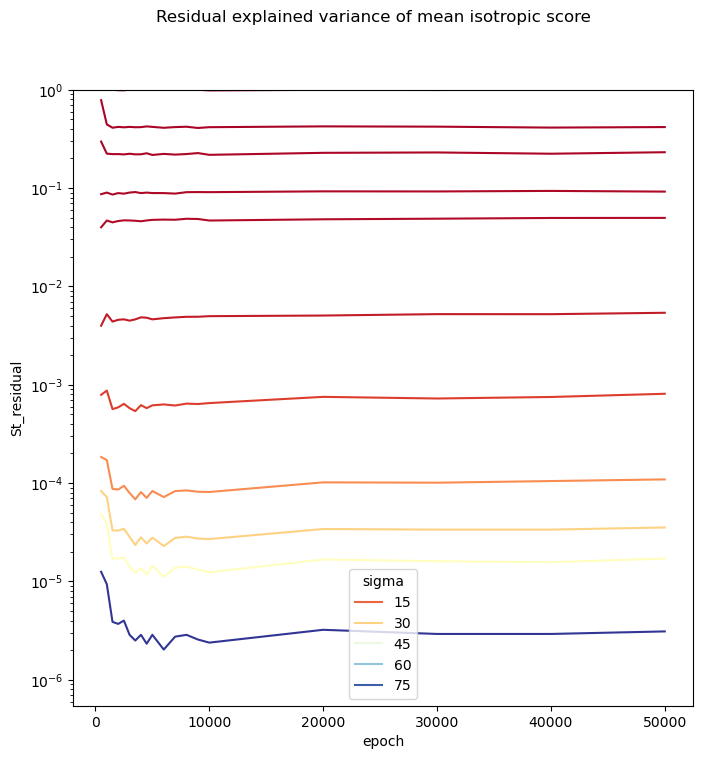

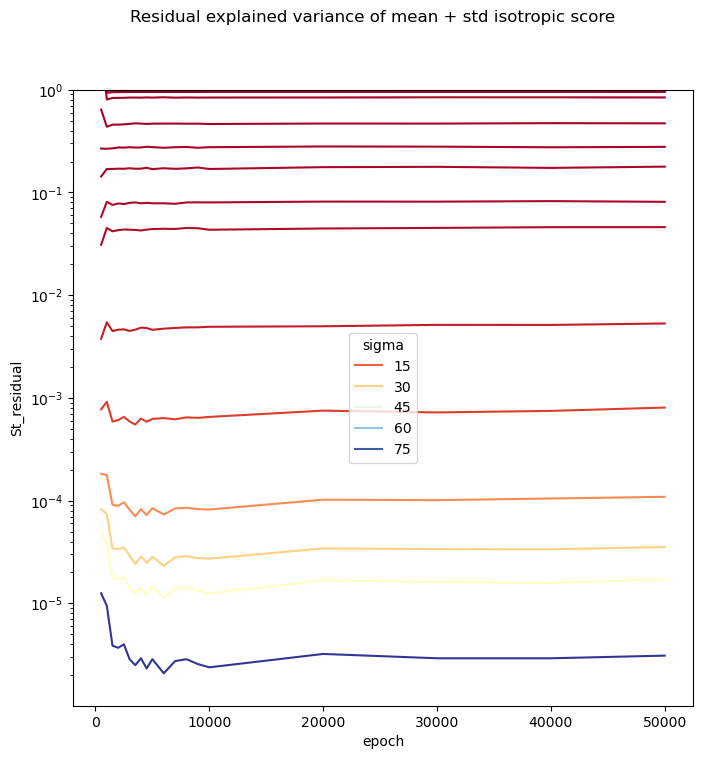

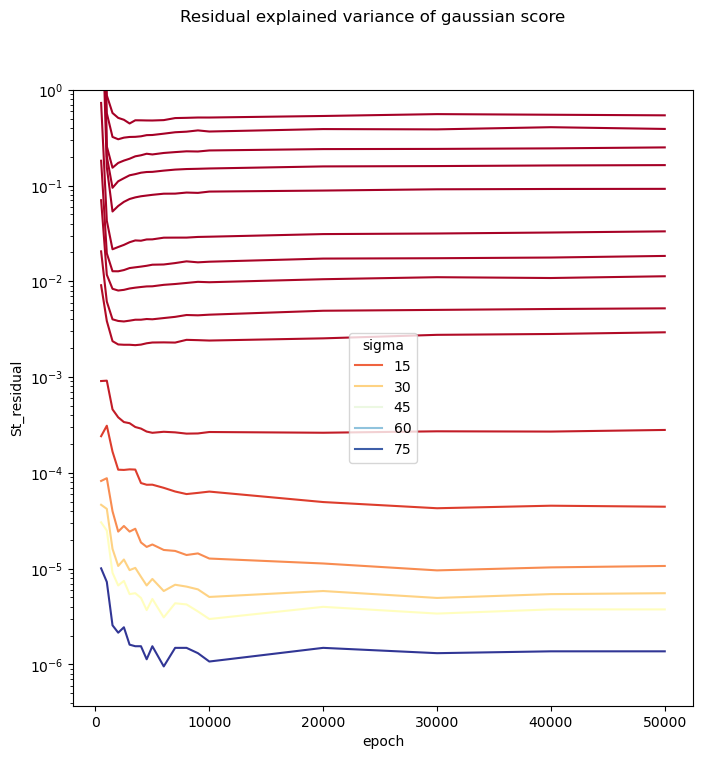

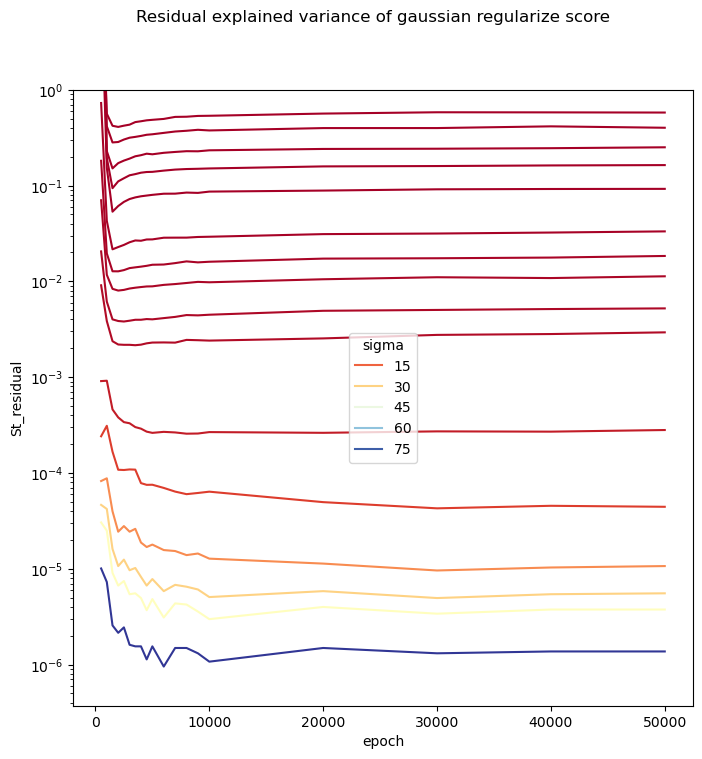

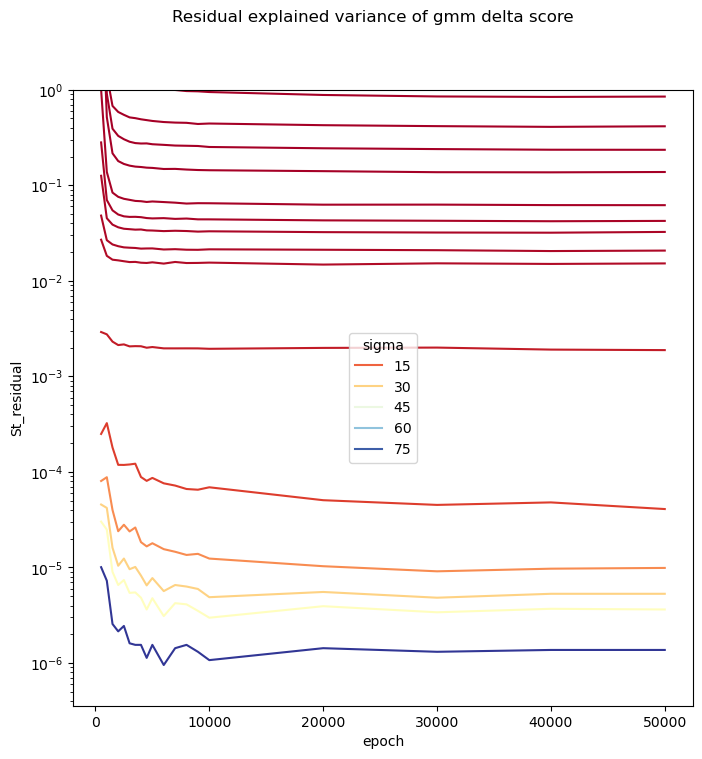

In [34]:
for name in ["mean isotropic", "mean + std isotropic", "gaussian", "gaussian regularize", "gmm delta"]:
    plt.figure(figsize=(8, 8))
    sns.lineplot(data=df_syn[(df_syn.name == name) & (df_syn.epoch > 0)], 
                x="epoch", y="St_residual", hue="sigma", palette="RdYlBu")
    plt.yscale("log")
    plt.ylim(None, 1)
    plt.suptitle(f"Residual explained variance of {name} score")
    plt.show()

In [ ]:

for name in ["mean isotropic", "mean + std isotropic", "gaussian", "gaussian regularize", "gmm delta"]:
    plt.figure(figsize=(8, 8))
    sns.lineplot(data=df_syn[(df_syn.name == name) & (df_syn.epoch > 0)], 
                x="epoch", y="Dt_residual", hue="sigma", palette="RdYlBu")
    plt.yscale("log")
    plt.ylim(None, 1)
    plt.suptitle(f"Residual explained variance of {name} score")
    plt.show()

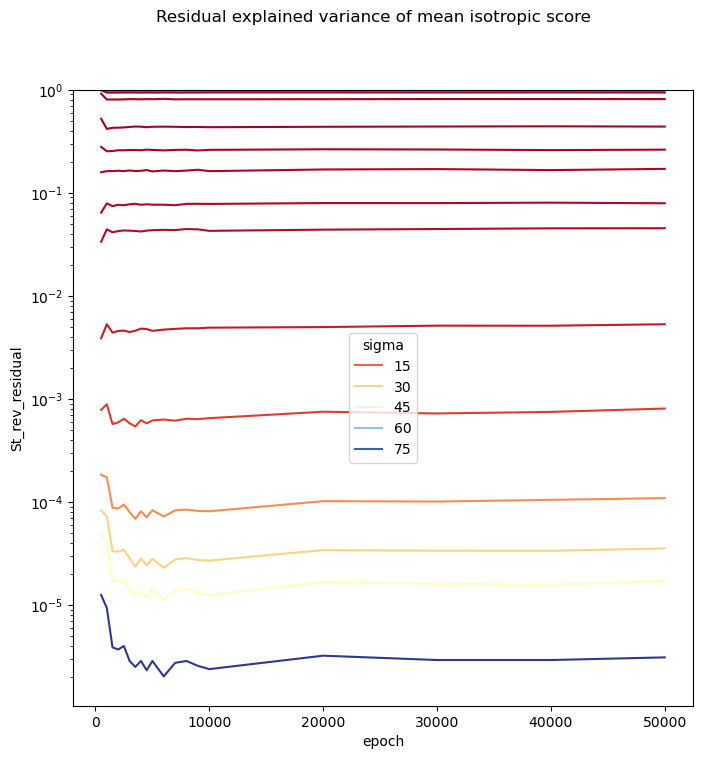

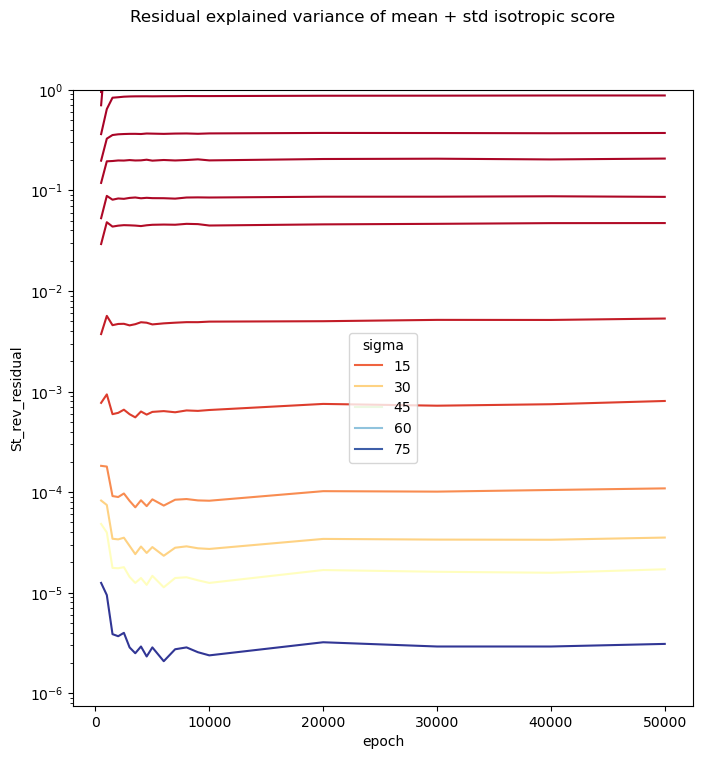

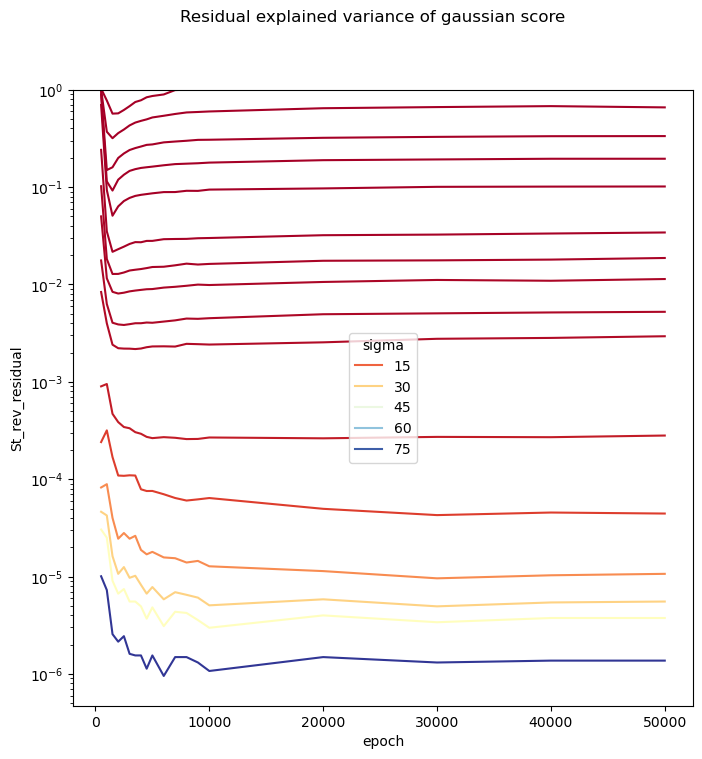

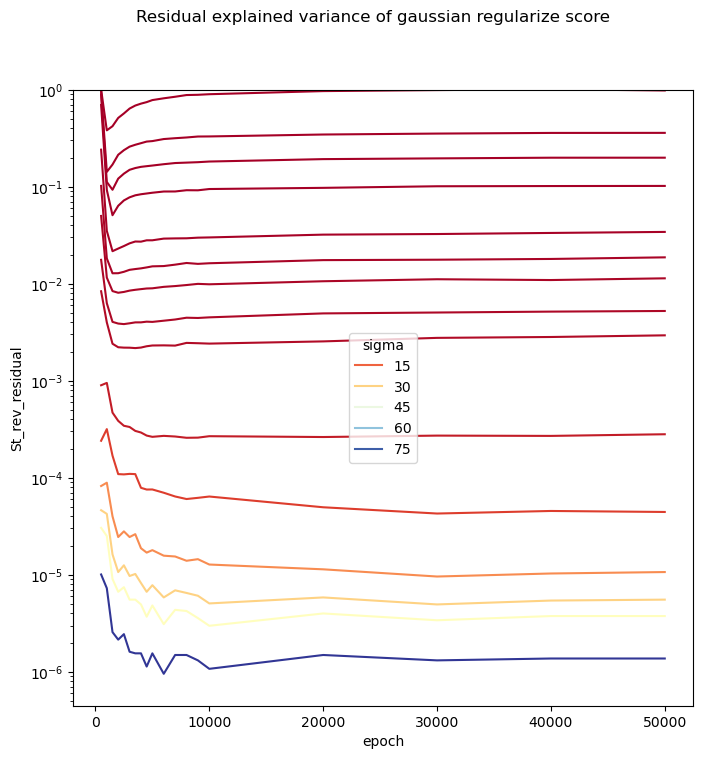

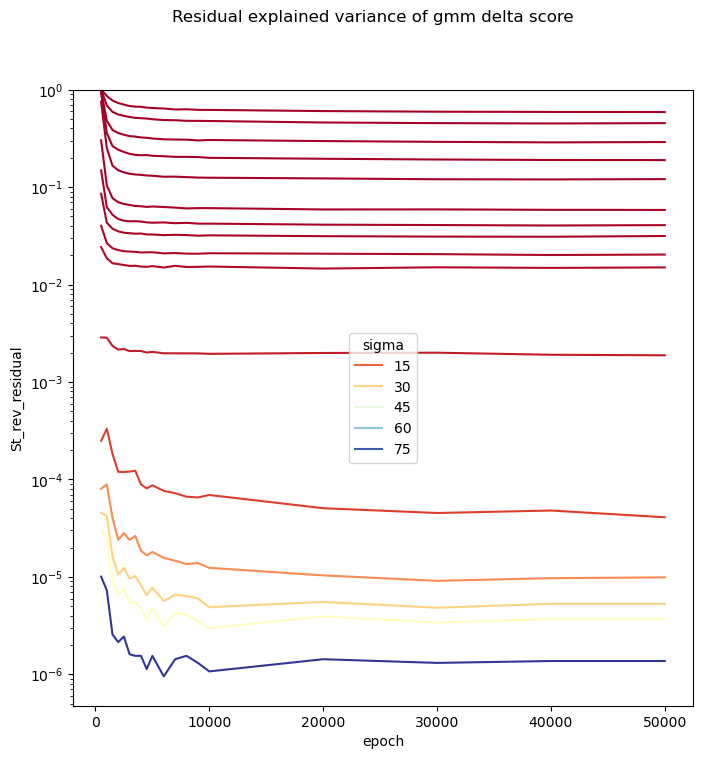

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
for name in ["mean isotropic", "mean + std isotropic", "gaussian", "gaussian regularize", "gmm delta"]:
    plt.figure(figsize=(8, 8))
    sns.lineplot(data=df_syn[(df_syn.name == name) & (df_syn.epoch > 0)], 
                x="epoch", y="St_rev_residual", hue="sigma", palette="RdYlBu")
    plt.yscale("log")
    plt.ylim(None, 1)
    plt.suptitle(f"Residual explained variance of {name} score")
    plt.show()

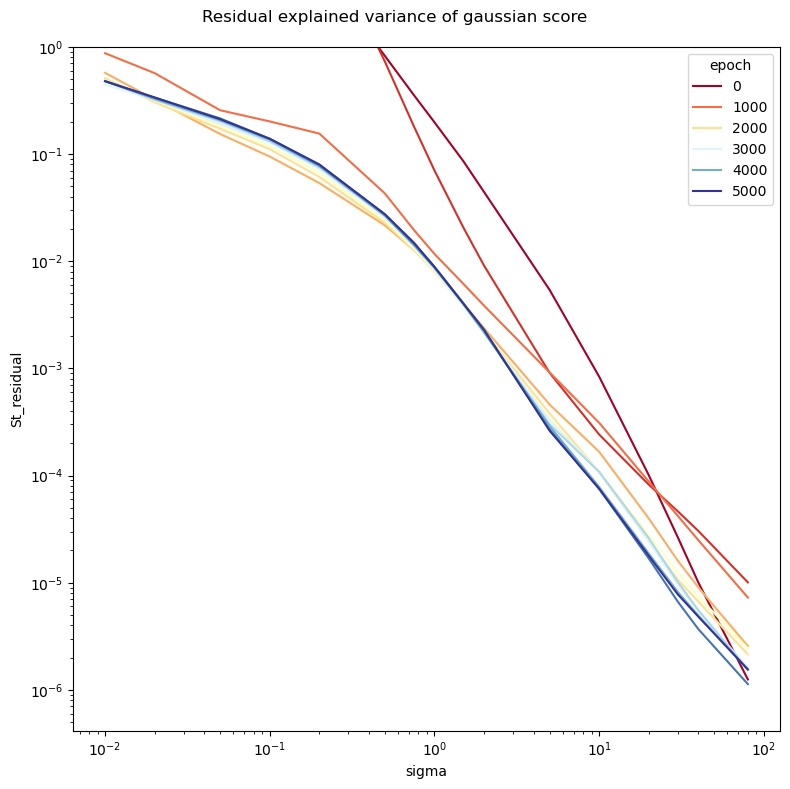

In [44]:
name = "gaussian" # "gaussian"
plt.figure(figsize=(8, 8))
sns.lineplot(data=df_syn[(df_syn.name == name) & (df_syn.epoch <=5000)], 
             x="sigma", y="St_residual", hue="epoch", palette="RdYlBu")
# sns.lineplot(data=df_syn[df_syn.name == "gmm delta"], x="sigma", y="St_residual", 
#              hue="epoch", palette="RdYlBu")
plt.yscale("log")
plt.xscale("log")
plt.ylim(None, 1)
plt.suptitle(f"Residual explained variance of {name} score")
plt.tight_layout()
plt.show()

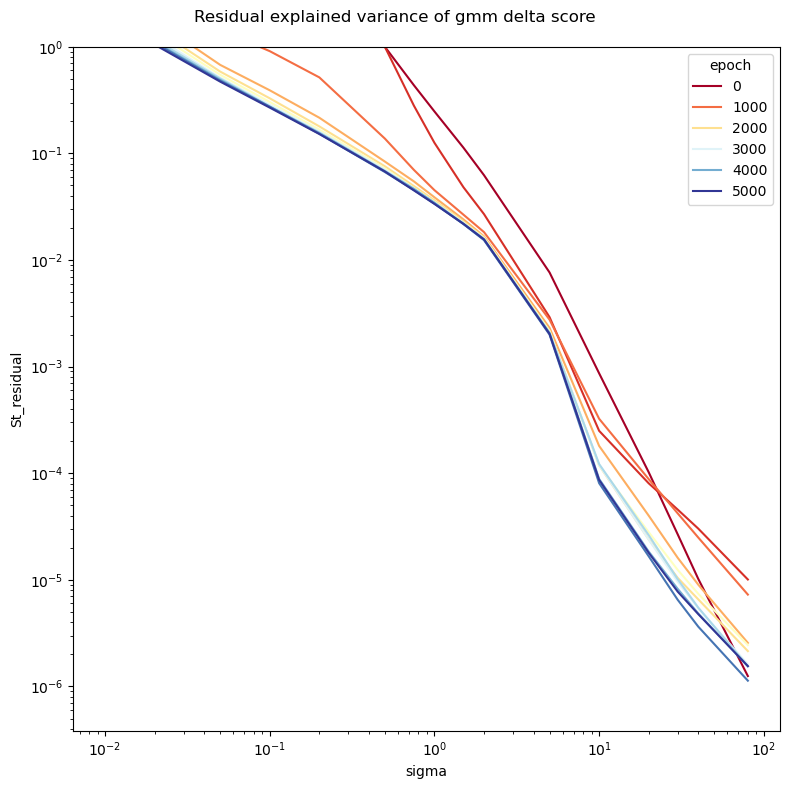

In [46]:
name = "gmm delta" # "gaussian"
plt.figure(figsize=(8, 8))
sns.lineplot(data=df_syn[(df_syn.name == name) & (df_syn.epoch <=5000)], 
             x="sigma", y="St_residual", hue="epoch", palette="RdYlBu")
# sns.lineplot(data=df_syn[df_syn.name == "gmm delta"], x="sigma", y="St_residual", 
#              hue="epoch", palette="RdYlBu")
plt.yscale("log")
plt.xscale("log")
plt.ylim(None, 1)
plt.suptitle(f"Residual explained variance of {name} score")
plt.tight_layout()
plt.show()

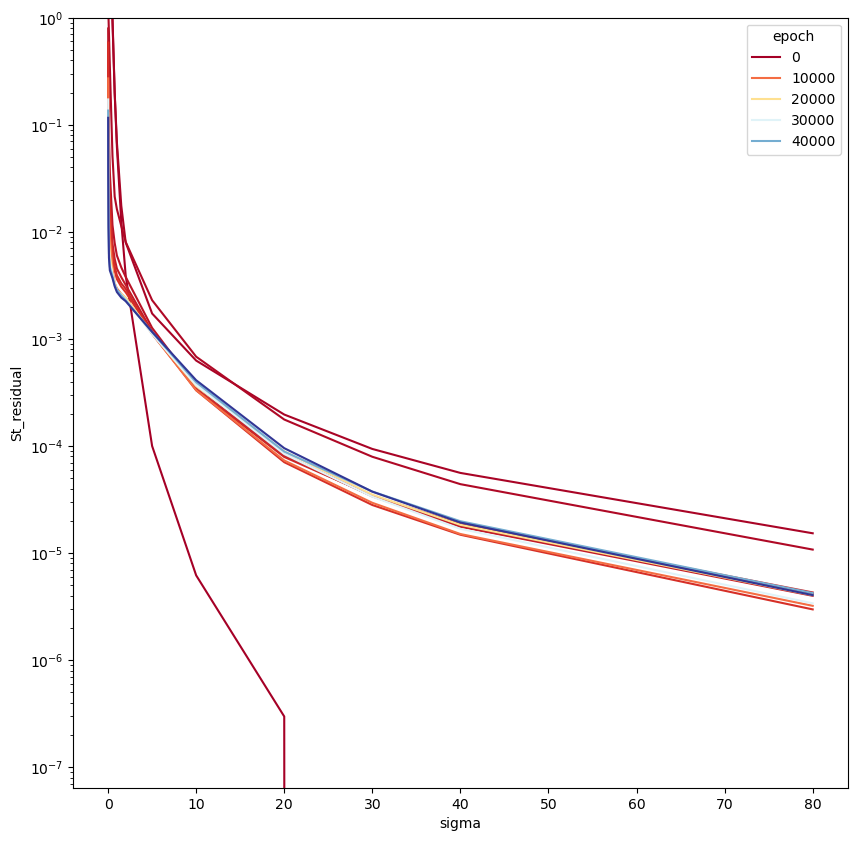

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
# sns.lineplot(data=df_syn[df_syn.name == "gaussian"], x="sigma", y="St_residual", 
#              hue="epoch", palette="Reds")
sns.lineplot(data=df_syn[df_syn.name == "gmm delta"], x="sigma", y="St_residual", 
             hue="epoch", palette="RdYlBu")
# plt.ylim(0, 1)
plt.yscale("log")
plt.ylim(None, 1)
plt.show()

## Compute General Gaussian Mixture 

In [10]:
from core.gaussian_mixture_lib import gaussian_mixture_score_batch_sigma_torch, \
    gaussian_mixture_lowrank_score_batch_sigma_torch, compute_cluster

In [12]:
kmeans_batch = 2048
kmeans_random_seed = 42
kmeans_verbose = 0
lambda_EPS = 1E-5
Us_col = {}
mus_col = {}
Lambdas_col = {}
weights_col = {}
for n_clusters in [2, 5, 10, 20, 50, 100,]:
    kmeans, eigval_mat, eigvec_mat, freq_vec, center_mat = compute_cluster(edm_Xmat.cpu(), 
                            n_clusters=n_clusters,
                            kmeans_batch=kmeans_batch, 
                            kmeans_random_seed=kmeans_random_seed,
                            kmeans_verbose=kmeans_verbose,
                            lambda_EPS=lambda_EPS)
    Us_col[n_clusters] = eigvec_mat #.to(device)
    mus_col[n_clusters] = center_mat #.to(device)
    Lambdas_col[n_clusters] = eigval_mat #.to(device)
    weights = freq_vec / freq_vec.sum()
    weights_col[n_clusters] = weights #.to(device)
    print(f"n_clusters={n_clusters}, computed.")
    # gaussian_mixture_score_batch_sigma_torch(x, mus, Us, Lambdas, weights=weights)

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  61939295.47736544


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:13<00:00,  6.65s/it]


cov PCA completed for each cluster.
n_clusters=2, computed.


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  53402954.75391725


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.76s/it]


cov PCA completed for each cluster.
n_clusters=5, computed.


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  49164096.15532214


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.51s/it]


cov PCA completed for each cluster.
n_clusters=10, computed.


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  45728992.4301963


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.13it/s]


cov PCA completed for each cluster.
n_clusters=20, computed.


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  42257640.46226799


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.99it/s]


cov PCA completed for each cluster.
n_clusters=50, computed.


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  39907317.86920489


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.67it/s]

cov PCA completed for each cluster.
n_clusters=100, computed.


### Score comparison of the final checkpoint

In [13]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_cifar10_20240130-2318/checkpoints"
epoch = 365000 # 49999
config = get_default_config("cifar10")
edm, _ = create_edm(join(ckptdir, f"ema_{epoch}.pth"), config,)
# edm, _ = create_edm(None, config,)
device = "cuda"
print("Explaining EDM score with GMM and other analytical scores")
df_col = []
target_name = "EDM"
for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0]:
    Xt = sample_Xt_batch(edm_Xmat, 1024, sigma=sigma)
    edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
    edm_Dt = edm_Dt.view(Xt.shape)
    score_edm = (edm_Dt - Xt) / (sigma**2)
    score_K_gmm_Xt = {}
    for n_clusters in [2, 5, 10, 20, 50, 100,]:
        score_K_gmm_Xt[n_clusters] = gaussian_mixture_score_batch_sigma_torch(Xt, 
            mus_col[n_clusters].cuda(), Us_col[n_clusters].cuda(), Lambdas_col[n_clusters].cuda() + sigma**2, 
            weights=weights_col[n_clusters].cuda(), )
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
    print(f"sigma={sigma}")
    df_col_part = []
    Dt_gmm = score_gmm_Xt * (sigma**2) + Xt
    for name, score in [("EDM", score_edm), 
                        ("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian regularize", score_gaussian_reg_Xt),
                        ("gmm_2_mode", score_K_gmm_Xt[2]),
                        ("gmm_5_mode", score_K_gmm_Xt[5]),
                        ("gmm_10_mode", score_K_gmm_Xt[10]),
                        ("gmm_20_mode", score_K_gmm_Xt[20]),
                        ("gmm_50_mode", score_K_gmm_Xt[50]),
                        ("gmm_100_mode", score_K_gmm_Xt[100]),
                        ("gmm delta", score_gmm_Xt),
                        ]:
        Dnoiser = score * (sigma**2) + Xt
        exp_var_vec = explained_var_vec(score_edm, score)
        exp_var_rev_vec = explained_var_vec(score, score_edm)
        exp_var_vec_Dt = explained_var_vec(edm_Dt, Dnoiser)
        exp_var_rev_vec_Dt = explained_var_vec(Dnoiser, edm_Dt)
        df_col_part.append({"sigma": sigma, "name": name, 
                       "St_EV": exp_var_vec.mean().item(), 
                       "St_EV_rev": exp_var_rev_vec.mean().item(), 
                       "Dt_EV": exp_var_vec_Dt.mean().item(), 
                       "Dt_EV_rev": exp_var_rev_vec_Dt.mean().item()})
    torch.cuda.empty_cache()
    df_col.extend(df_col_part)
    print(pd.DataFrame(df_col_part))

Explaining EDM score with GMM and other analytical scores
sigma=0.01
    sigma                  name        St_EV    St_EV_rev     Dt_EV  Dt_EV_rev
0    0.01                   EDM     1.000000     1.000000  1.000000   1.000000
1    0.01        mean isotropic -5847.656250     0.000899  0.034937 -29.887722
2    0.01  mean + std isotropic     0.001138 -1445.193359  0.999774   0.999774
3    0.01              gaussian     0.440412    -0.285580  0.999883   0.999883
4    0.01   gaussian regularize     0.405762    -2.725256  0.999868   0.999868
5    0.01            gmm_2_mode     0.469551    -0.247555  0.999888   0.999888
6    0.01            gmm_5_mode     0.491023    -0.021653  0.999892   0.999892
7    0.01           gmm_10_mode     0.504784     0.084855  0.999894   0.999894
8    0.01           gmm_20_mode     0.521909     0.225256  0.999896   0.999896
9    0.01           gmm_50_mode     0.483485     0.416614  0.999891   0.999891
10   0.01          gmm_100_mode     0.327296     0.486911  0.9

### Massive Compute with GMM of varying components

In [17]:
from tqdm import tqdm, trange

In [18]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_cifar10_20240130-2317/checkpoints"
config = get_default_config("cifar10")
device = "cuda"
print("Explaining EDM score with GMM and other analytical scores")
df_col = []
for epoch in tqdm([*range(0, 5000, 500), *range(5000, 10000, 1000), 
                   *range(10000, 50000, 5000), 49999]):
    if epoch == 0:
        edm, _ = create_edm(None, config,)
    else:
        edm, _ = create_edm(join(ckptdir, f"ema_{epoch}.pth"), config,)
    target_name = "EDM"
    for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0, 30.0, 40.0, 80.0]:
        Xt = sample_Xt_batch(edm_Xmat, 1000, sigma=sigma)
        edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
        edm_Dt = edm_Dt.view(Xt.shape)
        score_edm = (edm_Dt - Xt) / (sigma**2)
        score_K_gmm_Xt = {}
        for n_clusters in [2, 5, 10, 20, 50, 100,]:
            score_K_gmm_Xt[n_clusters] = gaussian_mixture_score_batch_sigma_torch(Xt, 
                mus_col[n_clusters].cuda(), Us_col[n_clusters].cuda(), Lambdas_col[n_clusters].cuda() + sigma**2, 
                weights=weights_col[n_clusters].cuda(), )
        score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
        score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
        score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
        score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
        score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
        Dt_gmm = score_gmm_Xt * (sigma**2) + Xt
        print(f"sigma={sigma}")
        df_col_part = []
        for name, score in [("EDM", score_edm), 
                        ("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian regularize", score_gaussian_reg_Xt),
                        ("gmm_2_mode", score_K_gmm_Xt[2]),
                        ("gmm_5_mode", score_K_gmm_Xt[5]),
                        ("gmm_10_mode", score_K_gmm_Xt[10]),
                        ("gmm_20_mode", score_K_gmm_Xt[20]),
                        ("gmm_50_mode", score_K_gmm_Xt[50]),
                        ("gmm_100_mode", score_K_gmm_Xt[100]),
                        ("gmm delta", score_gmm_Xt),
                        ]:
            Dnoiser = score * (sigma**2) + Xt
            exp_var_vec = explained_var_vec(score_edm, score)
            exp_var_rev_vec = explained_var_vec(score, score_edm)
            exp_var_vec_Dt = explained_var_vec(edm_Dt, Dnoiser)
            exp_var_rev_vec_Dt = explained_var_vec(Dnoiser, edm_Dt)
            St_var_vec = score.pow(2).sum(dim=1)
            Dt_var_vec = Dnoiser.pow(2).sum(dim=1)
            df_col_part.append({"epoch": epoch, "sigma": sigma, "name": name, 
                        "St_EV": exp_var_vec.mean().item(), 
                        "St_EV_std": exp_var_vec.std().item(),
                        "St_EV_rev": exp_var_rev_vec.mean().item(), 
                        "St_EV_rev_std": exp_var_rev_vec.std().item(),
                        "Dt_EV": exp_var_vec_Dt.mean().item(), 
                        "Dt_EV_std": exp_var_vec_Dt.std().item(),
                        "Dt_EV_rev": exp_var_rev_vec_Dt.mean().item(),
                        "Dt_EV_rev_std": exp_var_rev_vec_Dt.std().item(),
                        "St_Var": St_var_vec.mean().item(),
                        "St_Var_std": St_var_vec.std().item(),
                        "Dt_Var": Dt_var_vec.mean().item(), 
                        "Dt_Var_std": Dt_var_vec.std().item(),})
        df_col.extend(df_col_part)
        torch.cuda.empty_cache()
df_syn = pd.DataFrame(df_col)
df_syn["St_residual"] = 1 - df_syn["St_EV"]
df_syn["St_rev_residual"] = 1 - df_syn["St_EV_rev"]
df_syn["Dt_residual"] = 1 - df_syn["Dt_EV"]
df_syn["Dt_rev_residual"] = 1 - df_syn["Dt_EV_rev"]
df_syn.to_csv("edm_50k_epoch_gmm_exp_var.csv")
df_syn.to_csv(join(ckptdir, "..", "edm_50k_epoch_gmm_exp_var.csv"))

Explaining EDM score with GMM and other analytical scores


  0%|                                                                                                            | 0/24 [00:00<?, ?it/s]

No pretrained model path is provided, use the model at initialization.
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


  4%|████▏                                                                                               | 1/24 [00:21<08:06, 21.17s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


  8%|████████▎                                                                                           | 2/24 [00:42<07:44, 21.11s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 12%|████████████▌                                                                                       | 3/24 [01:03<07:26, 21.27s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 17%|████████████████▋                                                                                   | 4/24 [01:25<07:05, 21.29s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 21%|████████████████████▊                                                                               | 5/24 [01:46<06:43, 21.26s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 25%|█████████████████████████                                                                           | 6/24 [02:07<06:22, 21.26s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 29%|█████████████████████████████▏                                                                      | 7/24 [02:28<06:00, 21.23s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 33%|█████████████████████████████████▎                                                                  | 8/24 [02:49<05:40, 21.25s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 38%|█████████████████████████████████████▌                                                              | 9/24 [03:11<05:19, 21.31s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 42%|█████████████████████████████████████████▎                                                         | 10/24 [03:32<04:57, 21.25s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 46%|█████████████████████████████████████████████▍                                                     | 11/24 [03:53<04:36, 21.29s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 50%|█████████████████████████████████████████████████▌                                                 | 12/24 [04:15<04:15, 21.25s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 54%|█████████████████████████████████████████████████████▌                                             | 13/24 [04:36<03:54, 21.33s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 58%|█████████████████████████████████████████████████████████▊                                         | 14/24 [04:57<03:33, 21.35s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 62%|█████████████████████████████████████████████████████████████▉                                     | 15/24 [05:19<03:12, 21.36s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 67%|██████████████████████████████████████████████████████████████████                                 | 16/24 [05:40<02:49, 21.15s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 71%|██████████████████████████████████████████████████████████████████████▏                            | 17/24 [06:01<02:28, 21.15s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 18/24 [06:22<02:07, 21.19s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 79%|██████████████████████████████████████████████████████████████████████████████▍                    | 19/24 [06:43<01:46, 21.29s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 83%|██████████████████████████████████████████████████████████████████████████████████▌                | 20/24 [07:05<01:25, 21.29s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 88%|██████████████████████████████████████████████████████████████████████████████████████▋            | 21/24 [07:27<01:04, 21.43s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 92%|██████████████████████████████████████████████████████████████████████████████████████████▊        | 22/24 [07:48<00:42, 21.34s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████▉    | 23/24 [08:09<00:21, 21.38s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [08:30<00:00, 21.29s/it]

sigma=80.0


In [23]:
df_syn.sigma.unique()

array([1.0e-02, 2.0e-02, 5.0e-02, 1.0e-01, 2.0e-01, 5.0e-01, 7.5e-01,
       1.0e+00, 1.5e+00, 2.0e+00, 5.0e+00, 1.0e+01, 2.0e+01, 3.0e+01,
       4.0e+01, 8.0e+01])

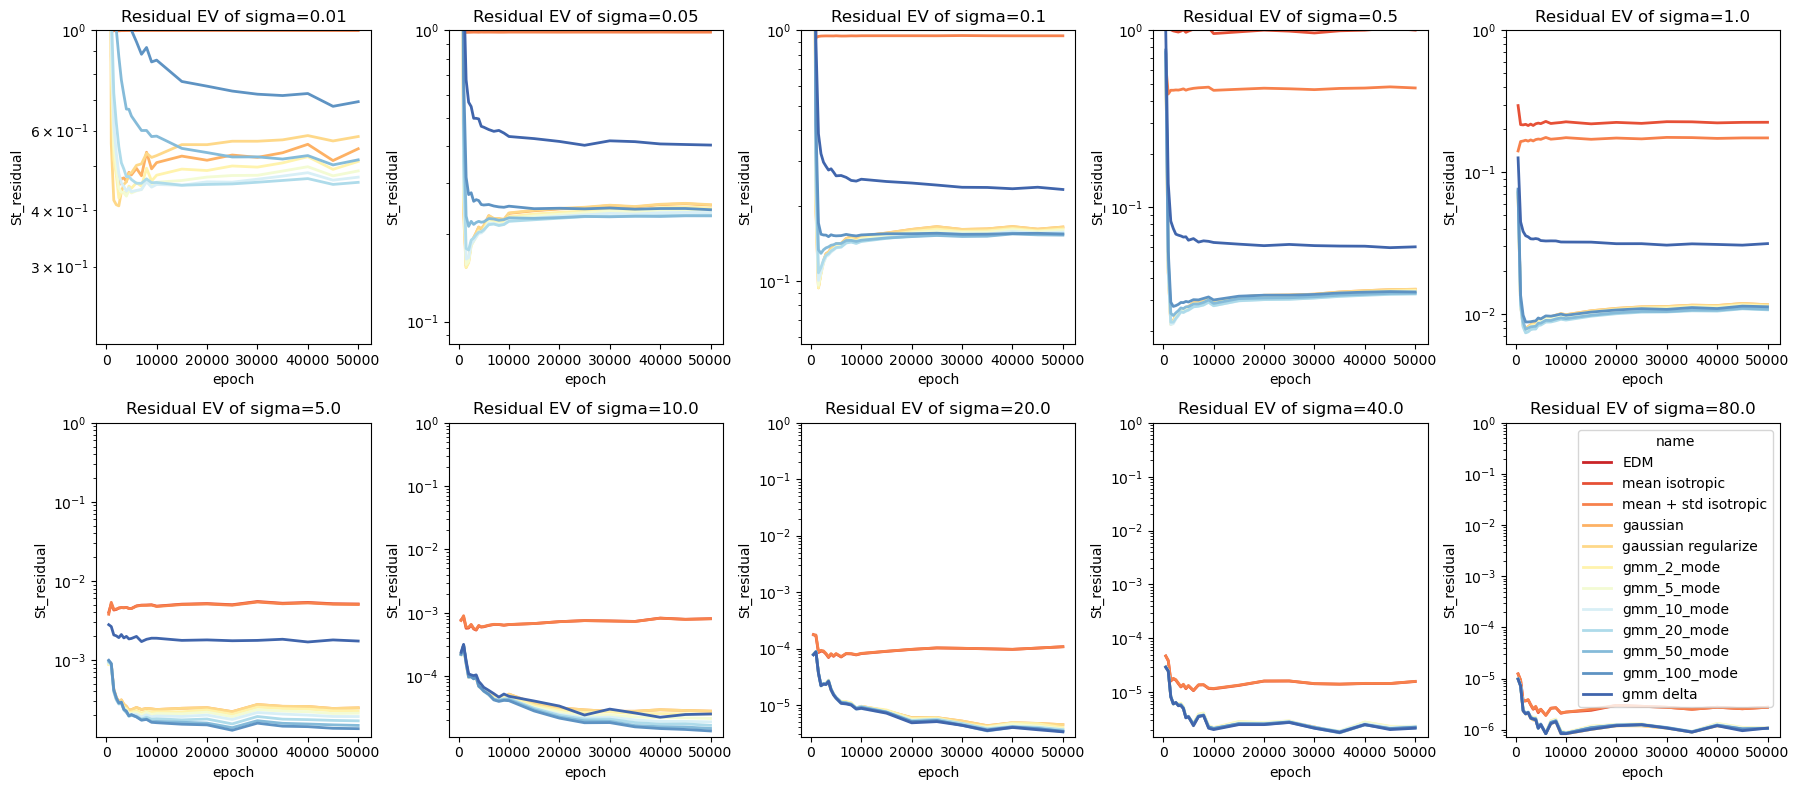

In [30]:
figh, axs = plt.subplots(2, 5, figsize=(18, 8))
axs = axs.flatten()
for i, sigma in enumerate([1.0e-02, 5.0e-02, 1.0e-01, 5.0e-01, 1.0e+00, 5.0e+00, 1.0e+01, 2.0e+01, 4.0e+01, 8.0e+01]):
    df_syn_sigma = df_syn[(df_syn.sigma == sigma) & (df_syn.epoch > 0)]
    sns.lineplot(data=df_syn_sigma, x="epoch", y="St_residual", hue="name", 
                 palette="RdYlBu", lw=2.0, ax=axs[i])
    axs[i].set_yscale("log")
    axs[i].set_ylim(None, 1)
    axs[i].set_title(f"Residual EV of sigma={sigma}")
    if i < 9:
        axs[i].legend().remove()
    # else:
        # set position of legend to be right outside of the plot
        # axs[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1))
# axs[-1].remove()
plt.tight_layout()
plt.suptitle("1 - explained variance of EDM by Gaussian and GMM scores")
plt.show()

### Massive Compute (Long time) with GMM of varying components

In [31]:
len([*range(0, 50000, 5000), *range(50000, 365000, 25000),])

23

In [33]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_cifar10_20240130-2318/checkpoints"
config = get_default_config("cifar10")
device = "cuda"
print("Explaining EDM score with GMM and other analytical scores")
df_col = []
for epoch in tqdm([*range(0, 50000, 5000), *range(50000, 365000, 25000),]):
    if epoch == 0:
        edm, _ = create_edm(None, config,)
    else:
        edm, _ = create_edm(join(ckptdir, f"ema_{epoch}.pth"), config,)
    target_name = "EDM"
    for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0, 30.0, 40.0, 80.0]:
        Xt = sample_Xt_batch(edm_Xmat, 1000, sigma=sigma)
        edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
        edm_Dt = edm_Dt.view(Xt.shape)
        score_edm = (edm_Dt - Xt) / (sigma**2)
        score_K_gmm_Xt = {}
        for n_clusters in [2, 5, 10, 20, 50, 100,]:
            score_K_gmm_Xt[n_clusters] = gaussian_mixture_score_batch_sigma_torch(Xt, 
                mus_col[n_clusters].cuda(), Us_col[n_clusters].cuda(), Lambdas_col[n_clusters].cuda() + sigma**2, 
                weights=weights_col[n_clusters].cuda(), )
        score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
        score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
        score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
        score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
        score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
        Dt_gmm = score_gmm_Xt * (sigma**2) + Xt
        print(f"sigma={sigma}")
        df_col_part = []
        for name, score in [("EDM", score_edm), 
                        ("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian regularize", score_gaussian_reg_Xt),
                        ("gmm_2_mode", score_K_gmm_Xt[2]),
                        ("gmm_5_mode", score_K_gmm_Xt[5]),
                        ("gmm_10_mode", score_K_gmm_Xt[10]),
                        ("gmm_20_mode", score_K_gmm_Xt[20]),
                        ("gmm_50_mode", score_K_gmm_Xt[50]),
                        ("gmm_100_mode", score_K_gmm_Xt[100]),
                        ("gmm delta", score_gmm_Xt),
                        ]:
            Dnoiser = score * (sigma**2) + Xt
            exp_var_vec = explained_var_vec(score_edm, score)
            exp_var_rev_vec = explained_var_vec(score, score_edm)
            exp_var_vec_Dt = explained_var_vec(edm_Dt, Dnoiser)
            exp_var_rev_vec_Dt = explained_var_vec(Dnoiser, edm_Dt)
            St_var_vec = score.pow(2).sum(dim=1)
            Dt_var_vec = Dnoiser.pow(2).sum(dim=1)
            df_col_part.append({"epoch": epoch, "sigma": sigma, "name": name, 
                        "St_EV": exp_var_vec.mean().item(), 
                        "St_EV_std": exp_var_vec.std().item(),
                        "St_EV_rev": exp_var_rev_vec.mean().item(), 
                        "St_EV_rev_std": exp_var_rev_vec.std().item(),
                        "Dt_EV": exp_var_vec_Dt.mean().item(), 
                        "Dt_EV_std": exp_var_vec_Dt.std().item(),
                        "Dt_EV_rev": exp_var_rev_vec_Dt.mean().item(),
                        "Dt_EV_rev_std": exp_var_rev_vec_Dt.std().item(),
                        "St_Var": St_var_vec.mean().item(),
                        "St_Var_std": St_var_vec.std().item(),
                        "Dt_Var": Dt_var_vec.mean().item(), 
                        "Dt_Var_std": Dt_var_vec.std().item(),})
        df_col.extend(df_col_part)
        torch.cuda.empty_cache()
df_syn = pd.DataFrame(df_col)
df_syn["St_residual"] = 1 - df_syn["St_EV"]
df_syn["St_rev_residual"] = 1 - df_syn["St_EV_rev"]
df_syn["Dt_residual"] = 1 - df_syn["Dt_EV"]
df_syn["Dt_rev_residual"] = 1 - df_syn["Dt_EV_rev"]
df_syn.to_csv("edm_365k_epoch_gmm_exp_var.csv")
df_syn.to_csv(join(ckptdir, "..", "edm_365k_epoch_gmm_exp_var.csv"))

Explaining EDM score with GMM and other analytical scores


  0%|                                                                                                            | 0/23 [00:00<?, ?it/s]

No pretrained model path is provided, use the model at initialization.
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


  4%|████▎                                                                                               | 1/23 [00:20<07:36, 20.73s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


  9%|████████▋                                                                                           | 2/23 [00:42<07:28, 21.33s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 13%|█████████████                                                                                       | 3/23 [01:03<07:05, 21.28s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 17%|█████████████████▍                                                                                  | 4/23 [01:24<06:43, 21.23s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 22%|█████████████████████▋                                                                              | 5/23 [01:45<06:20, 21.13s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 26%|██████████████████████████                                                                          | 6/23 [02:06<05:55, 20.88s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 30%|██████████████████████████████▍                                                                     | 7/23 [02:27<05:36, 21.03s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 35%|██████████████████████████████████▊                                                                 | 8/23 [02:49<05:18, 21.23s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 39%|███████████████████████████████████████▏                                                            | 9/23 [03:10<04:56, 21.19s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 43%|███████████████████████████████████████████                                                        | 10/23 [03:31<04:36, 21.24s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 48%|███████████████████████████████████████████████▎                                                   | 11/23 [03:52<04:14, 21.20s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 52%|███████████████████████████████████████████████████▋                                               | 12/23 [04:14<03:53, 21.23s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 57%|███████████████████████████████████████████████████████▉                                           | 13/23 [04:35<03:32, 21.23s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 61%|████████████████████████████████████████████████████████████▎                                      | 14/23 [04:56<03:10, 21.17s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 65%|████████████████████████████████████████████████████████████████▌                                  | 15/23 [05:17<02:48, 21.12s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 70%|████████████████████████████████████████████████████████████████████▊                              | 16/23 [05:38<02:27, 21.07s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 74%|█████████████████████████████████████████████████████████████████████████▏                         | 17/23 [05:59<02:06, 21.12s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 78%|█████████████████████████████████████████████████████████████████████████████▍                     | 18/23 [06:20<01:46, 21.21s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 83%|█████████████████████████████████████████████████████████████████████████████████▊                 | 19/23 [06:42<01:24, 21.20s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 87%|██████████████████████████████████████████████████████████████████████████████████████             | 20/23 [07:02<01:03, 21.08s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 91%|██████████████████████████████████████████████████████████████████████████████████████████▍        | 21/23 [07:24<00:42, 21.28s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████▋    | 22/23 [07:45<00:21, 21.14s/it]

sigma=80.0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [08:06<00:00, 21.16s/it]

sigma=80.0


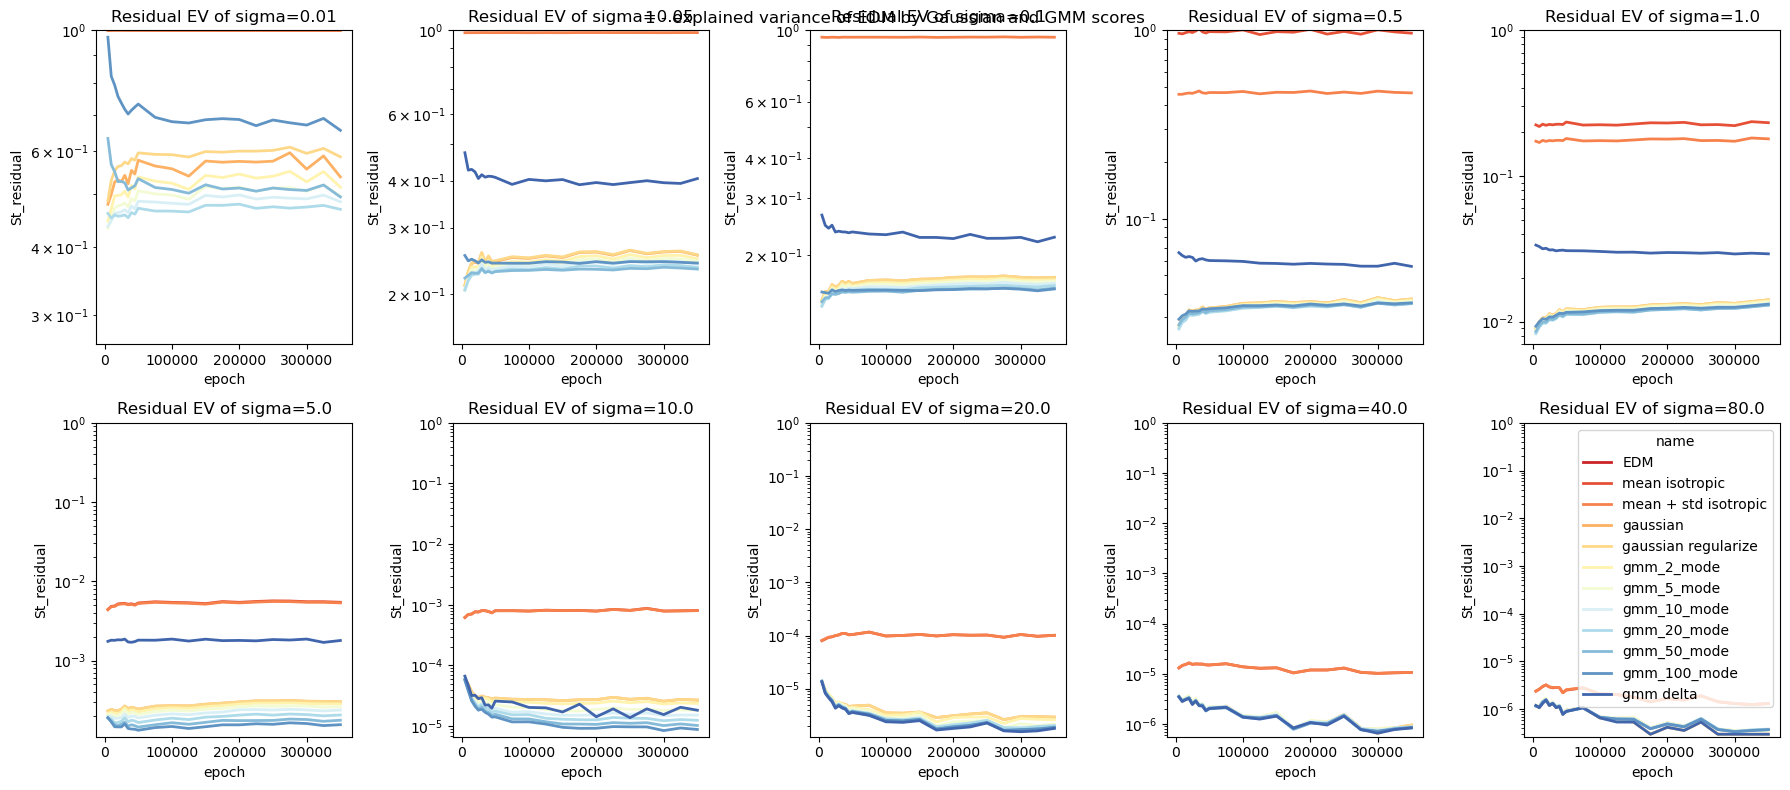

In [34]:
figh, axs = plt.subplots(2, 5, figsize=(18, 8))
axs = axs.flatten()
for i, sigma in enumerate([1.0e-02, 5.0e-02, 1.0e-01, 5.0e-01, 1.0e+00, 5.0e+00, 1.0e+01, 2.0e+01, 4.0e+01, 8.0e+01]):
    df_syn_sigma = df_syn[(df_syn.sigma == sigma) & (df_syn.epoch > 0)]
    sns.lineplot(data=df_syn_sigma, x="epoch", y="St_residual", hue="name", 
                 palette="RdYlBu", lw=2.0, ax=axs[i])
    axs[i].set_yscale("log")
    axs[i].set_ylim(None, 1)
    axs[i].set_title(f"Residual EV of sigma={sigma}")
    if i < 9:
        axs[i].legend().remove()
    # else:
        # set position of legend to be right outside of the plot
        # axs[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1))
# axs[-1].remove()
plt.tight_layout()
plt.suptitle("1 - explained variance of EDM by Gaussian and GMM scores")
plt.show()

### Scratch zone

In [ ]:
n_clusters = 10
kmeans_batch = 2048
kmeans_random_seed = 42
kmeans_verbose = 1
lambda_EPS = 1E-4
kmeans, eigval_mat, eigvec_mat, freq_vec, center_mat = compute_cluster(edm_Xmat.cpu(), 
                          n_clusters,
                          kmeans_batch=kmeans_batch, 
                          kmeans_random_seed=kmeans_random_seed,
                          kmeans_verbose=kmeans_verbose,
                          lambda_EPS=lambda_EPS)

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Init 1/3 with method k-means++
Inertia for init 1/3: 4384964.315083331
Init 2/3 with method k-means++
Inertia for init 2/3: 4857273.866972087
Init 3/3 with method k-means++
Inertia for init 3/3: 4338331.756928748
[MiniBatchKMeans] Reassigning 1 cluster centers.
Minibatch step 1/4882: mean batch inertia: 702.1448527094404
Minibatch step 2/4882: mean batch inertia: 534.3755583972969, ewa inertia: 534.3755583972969
Minibatch step 3/4882: mean batch inertia: 513.6588740823362, ewa inertia: 533.5270114932252
Minibatch step 4/4882: mean batch inertia: 508.15930290837963, ewa inertia: 532.4879605400995
Minibatch step 5/4882: mean batch inertia: 515.6273936897132, ewa inertia: 531.7973586279268
Minibatch step 6/4882: mean batch inertia: 502.8440732454901, ewa inertia: 530.6114439178093
Minibatch step 7/4882: mean batch inertia: 512.0280302326893, ewa inertia: 529.8502749049569
Minibatch step 8/4882: mean batch inertia: 499.88022142676755, ewa inertia: 528.6227137901014
Minibatch step 9/4882: m

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.57s/it]

cov PCA completed for each cluster.
